## Conditional Deep Convolutional GAN [CDCGANS]
    
    Conditional DCGANS introduce the conditional version of generative adversarial nets, which can be constructed by simply feeding the data, labels, that we wish to condition on to both the generator and discriminator.

> This notebook explains generation of the Artificial Bitmoji Faces based upon the user provided labels. 

### 1. Dataset Creation and Visualization

In [1]:
"""Import Packages"""

import os 
import cv2
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
from tqdm.notebook import tqdm
from torchview import draw_graph # Ref and credits: https://github.com/mert-kurttutan/torchview for visualizing model graph.
import numpy as np
from PIL import Image
%matplotlib inline

In [2]:
"""Images Directory"""
# Dataset Ref: https://www.kaggle.com/datasets/mostafamozafari/bitmoji-faces

Root_Directory = './Bitmoji_Faces/BitmojiDataset'
for l in os.listdir(Root_Directory):
    if os.path.isdir(os.path.join(Root_Directory, ''.join(l))):
        Directory = os.path.join(Root_Directory, ''.join(l))
Bitmoji_Images = os.listdir(Directory)
len(Bitmoji_Images)

4084

In [3]:
"""Class CSV with Image_ID and Gender Class."""

csv_directory = os.path.join(Root_Directory, 'attributes.csv')
Class = pd.read_csv(csv_directory)

In [4]:
"""Rename Target Column."""

print(Class.head())
Class = Class.rename(columns = {'is_male': 'Gender'})
Class.head()

   image_id  is_male
0  0000.jpg        1
1  0001.jpg       -1
2  0002.jpg        1
3  0003.jpg       -1
4  0004.jpg       -1


image_id  Gender
0  0000.jpg       1
1  0001.jpg      -1
2  0002.jpg       1
3  0003.jpg      -1
4  0004.jpg      -1

In [5]:
"""Replace -1 to 0 for Female Category."""

Class['Gender'] = Class['Gender'].apply(lambda x: 0 if x == -1 else x) # 1 - Male, 0 - Female
Class.head()

image_id  Gender
0  0000.jpg       1
1  0001.jpg       0
2  0002.jpg       1
3  0003.jpg       0
4  0004.jpg       0

In [6]:
"""Creating Custom Dataset with Images and Labels from CSV file."""

class Image_Label_Dataset(Dataset):
    def __init__(self, Image_folder, Class_csv, transforms):
        self.df = Class_csv
        self.images_folder = Image_folder
        self.transform = transforms

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        filename = self.df['image_id'][idx]
        label = self.df['Gender'][idx]
        image = Image.open(os.path.join(self.images_folder, filename))
        image = self.transform(image)
        return image, label

In [7]:
"""Parameters"""

image_size = (64, 64)
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [8]:
"""Transformations for Image."""

transform = T.Compose([
                      T.Resize(image_size), 
                      T.CenterCrop(image_size),
                      T.ToTensor(),
                      T.Normalize(*stats)])

In [9]:
Dataset = Image_Label_Dataset(Directory, Class, transform)

In [10]:
"""Creating DataLoader from above dataset."""

Train_Dl = DataLoader(Dataset, batch_size, shuffle = True, num_workers = 0)

In [11]:
"""Functions to show images in batch."""

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax = 64):
    fig, ax = plt.subplots(figsize = (8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.cpu().detach()[:nmax]), nrow = 8).permute(1, 2, 0))

def show_batch(dl, nmax = 64):
    for images, _ in dl:
        show_images(images, nmax)
        break

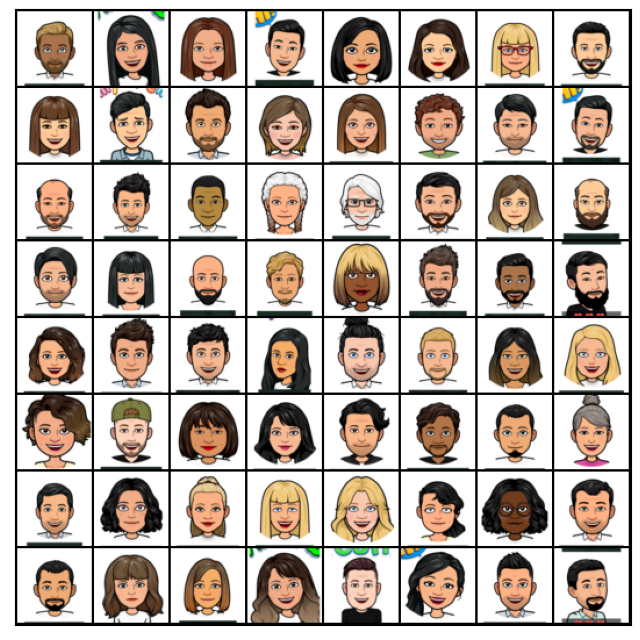

In [12]:
show_batch(Train_Dl)

In [13]:
def get_default_device():
    """Use GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move Tensors to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a Dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
"""Check for the device."""
device = get_default_device()
device

device(type='cuda')

In [15]:
"""Moving DataLoader to the respective Device."""
Train_Dl = DeviceDataLoader(Train_Dl, device)
Train_Dl

In [16]:
Label = {"female" : 0, "male" : 1}
Label_size = len(Label)
print(Label_size)

2


### 2. Label Embeddings

In [17]:
"""Using GloVE Embeddings.(Dimension - 100)"""

# Ref: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
# Getting the pre-trained embeddings.
embeddings_index = dict()
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [18]:
"""Create a weight matrix for words in Labels."""

embedding_matrix = np.zeros((Label_size, 100))
for word, i in Label.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_matrix = to_device(torch.from_numpy(embedding_matrix).float(), device)

### 3. Model

In [19]:
"""Function for Discriminator Convolutoinal Block."""

def conv_block(in_channels, out_channels):
    block = [nn.Conv2d(in_channels, out_channels, kernel_size= (4, 4), stride = (2, 2), padding = 1, bias = False),
                          nn.BatchNorm2d(out_channels),
                          nn.LeakyReLU(0.2, inplace = True)]
    return block

In [20]:
"""Function for Generator Convolutoinal Block."""

def conv_tr_block(in_channels, out_channels):
    layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size = (4, 4), stride = (2, 2), padding = 1, bias = False),
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(True)]
    return layers

In [21]:
"""Function for Weight Intialization of Generator."""

def weight_initialize_gen(layer):
            type_ = type(layer)
            if type_ == nn.ConvTranspose2d:
                nn.init.normal_(layer.weight.data, 0.0, 0.02)
            elif type_ == nn.BatchNorm2d:
                nn.init.normal_(layer.weight.data, 1.0, 0.1)
                nn.init.constant_(layer.bias, 0)

In [22]:
"""Function for Weight Intialization of Discriminator."""

def weight_initialize_dis(layer):
            type_ = type(layer)
            if type_ == nn.Conv2d:
                nn.init.normal_(layer.weight.data, 0.0, 0.02)
            elif type_ == nn.BatchNorm2d:
                nn.init.normal_(layer.weight.data, 1.0, 0.1)
                nn.init.constant_(layer.bias, 0)

In [23]:
"""Discriminator Class"""

class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(*conv_block(6, 64), # IN(6, 64, 64) OUT(64, 32, 32) 
                              *conv_block(64, 128), # IN(64, 32, 32) OUT(128, 16, 16)
                              *conv_block(128, 256), # IN(128, 16, 16) OUT(256, 8, 8)
                              nn.Dropout(0.2),
                              *conv_block(256, 512), # IN(256, 8, 8) OUT(512, 4, 4)
                              nn.Dropout(0.2),
                              nn.Conv2d(512, 1, kernel_size = (4, 4), stride = (1, 1), padding = 0, bias = False), # IN(512, 4, 4) OUT(1, 1, 1)
                              nn.Flatten(),
                              nn.Sigmoid())
        
        self.embedding = nn.Embedding(Label_size, 100).from_pretrained(embedding_matrix)
        self.linear_out_dim = image_size[0] * image_size[1] * 3
        self.linear = nn.Linear(100, self.linear_out_dim, bias = False)
        nn.init.normal_(self.linear.weight.data, 0.0, 0.02)
        
    def forward(self, img, l):
        label_out = self.embedding(l) # IN(1) OUT(1, 100)
        label_out = self.linear(label_out) # IN(1, 100) OUT(1, 12288)
        label_out = label_out.view(label_out.size(0), 3, image_size[0], image_size[1]) # OUT(3, 64, 64)
        out = torch.cat((img, label_out), 1) # OUT(6, 64, 64)
        out = self.discriminator(out)
        return out
    

In [24]:
"""Generator Class"""

class Generator(nn.Module):

    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
                            nn.ConvTranspose2d(1040, 512, kernel_size = (1, 1), stride = (1, 1), padding = 0, bias = False), # IN(1040, 4, 4) OUT(512, 4, 4)
                            nn.BatchNorm2d(512), 
                            nn.ReLU(True),

                            *conv_tr_block(512, 256), # IN(512, 4, 4) OUT(256, 8, 8)
                            *conv_tr_block(256, 128), # IN(256, 8, 8) OUT(128, 16, 16)
                            *conv_tr_block(128, 64), # IN(128 16, 16) OUT(64, 32, 32)
                            nn.ConvTranspose2d(64, 3, kernel_size = (4, 4), stride = (2, 2), padding = 1, bias = False), # IN(64, 32, 32) OUT(3, 64, 64)
                            nn.Tanh())
        self.img_size_half = image_size[0] // 2
        self.linear_img = nn.Linear(latent_dim, 512 * self.img_size_half, bias = False)
        self.embedding = nn.Embedding(Label_size, 100).from_pretrained(embedding_matrix)
        self.linear_label = nn.Linear(100, 4 * 4 * 16, bias = False)
        nn.init.normal_(self.linear_label.weight.data, 0.0, 0.02)
        nn.init.normal_(self.linear_img.weight.data, 0.0, 0.02)

    
    def forward(self, latent_vector, l):
        out_label = self.embedding(l) # IN(1) OUT(1, 100)
        out_label = self.linear_label(out_label) # IN(1, 100) OUT(1, 256)
        out_label = out_label.view(out_label.size(0), 16, 4, 4) # OUT(16, 4, 4)

        out_img = self.linear_img(latent_vector) #IN(128) OUT(16384)
        #print(out_img.size())
        shape = (out_img.size(0) * out_img.size(1)) // (out_img.size(0) * 1024)
        out_img = out_img.view(out_img.size(0), 1024, int(np.sqrt(shape)), int(np.sqrt(shape)))
        #print(out_img.size())
        out = torch.cat((out_img, out_label), 1) # OUT(1040, 4, 4)
        out = self.generator(out)
        return out

In [25]:
latent_dim = 128 # Latent Vector Dimension
discriminator = Discriminator()
generator = Generator(latent_dim)

In [26]:
"""Apply Weights and Transfer to Device."""
discriminator.apply(weight_initialize_dis)
to_device(discriminator, device)

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2, inp

In [27]:
"""Apply Weights and Transfer to Device."""
generator.apply(weight_initialize_gen)
to_device(generator, device)

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(1040, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()


In [28]:
img_dummy = torch.randn(batch_size, 3, 64, 64, device = device)
labels_dummy = torch.randint(0, 2, size = (batch_size, 1), device = device, dtype = torch.int64)
latent_dummy = torch.randn(batch_size, latent_dim, device = device) 


(process:57320): Pango-WARNING **: 12:48:54.926: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


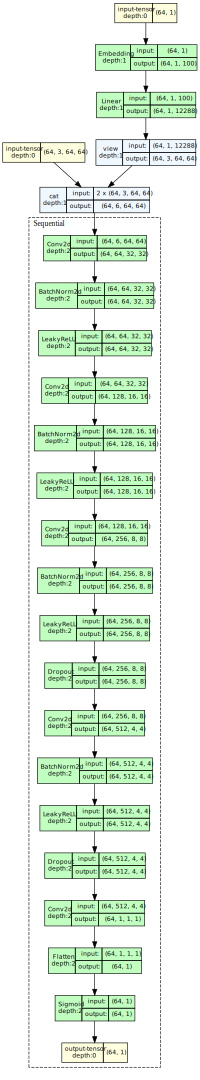

In [29]:
"""Graph of Discriminator."""
model_graph = draw_graph(discriminator, input_data = (img_dummy, labels_dummy), device = 'cuda', expand_nested=True)
model_graph.visual_graph


(process:41484): Pango-WARNING **: 12:48:55.179: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


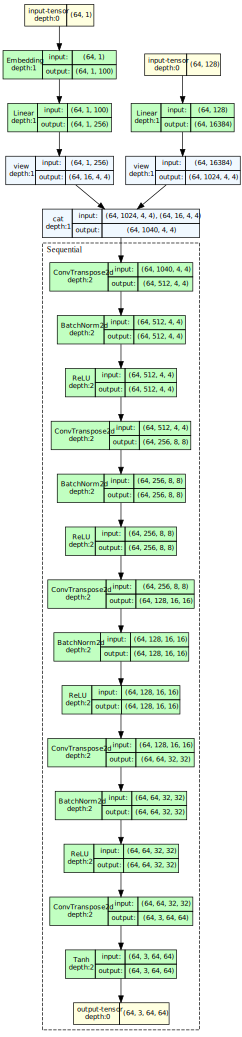

In [30]:
"""Graph of Generator."""
model_graph = draw_graph(generator, input_data = (latent_dummy, labels_dummy), device = 'cuda', expand_nested = True)
model_graph.visual_graph

torch.Size([64, 3, 64, 64])


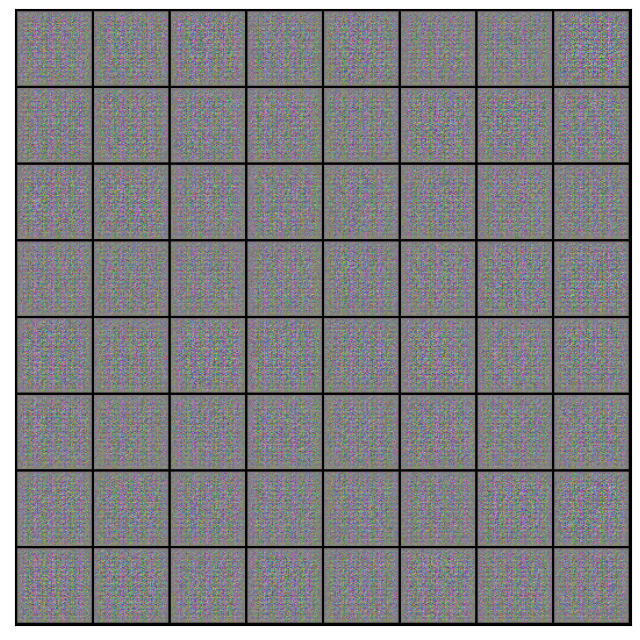

In [31]:
xb = torch.randn(batch_size, latent_dim, device = device) # random latent tensors
yb = torch.randint(0, 2, size = (batch_size, 1), device = device, dtype = torch.int64)
fake_images = generator(xb, yb)
print(fake_images.shape)
show_images(fake_images)

### 4. Train Functions

In [32]:
"""Train Function for Discriminator."""

def Train_Discriminator(true_images, true_labels, Opt_D):
    Opt_D.zero_grad()

    """True Dataset Prediction"""
    true_pred = discriminator(true_images, true_labels)
    true_targets = torch.ones(true_images.size(0), 1, device = device)
    true_loss = F.binary_cross_entropy(true_pred, true_targets)
    true_score = torch.mean(true_pred).item()

    """Fake Dataset Generation"""
    fake_data = torch.randn(batch_size, latent_dim, device = device)
    fake_labels = torch.randint(0, 2, size = (batch_size, 1), device = device, dtype = torch.int64)
    fake_images = generator(fake_data, fake_labels)

    """Fake Dataset Prediction"""
    fake_pred = discriminator(fake_images, fake_labels)
    fake_targets = torch.zeros(fake_images.size(0), 1, device = device)
    fake_loss = F.binary_cross_entropy(fake_pred, fake_targets)
    fake_score = torch.mean(fake_pred).item()

    """Loss Computation of both True and Fake"""
    loss = true_loss + fake_loss
    loss.backward()
    Opt_D.step()

    return loss.item(), true_score, fake_score


In [33]:
"""Train Function for Generator."""

def Train_Generator(Opt_G):
    Opt_G.zero_grad()

    """Fake Dataset Generation"""
    fake_data = torch.randn(batch_size, latent_dim, device = device)
    fake_labels = torch.randint(0, 2, size = (batch_size, 1), device = device, dtype = torch.int64)
    fake_images = generator(fake_data, fake_labels)

    """Fake Dataset Prediction - Making the Discriminator to predict this Adversial Data as True Image, 
       so that Generator updates itself in improving the quality of generation.
    """
    pred = discriminator(fake_images, fake_labels)
    targets = torch.ones(fake_images.size(0), 1, device = device)
    loss = F.binary_cross_entropy(pred, targets)
    fake_score = torch.mean(pred).item()

    loss.backward()
    Opt_G.step()

    return loss.item()

In [34]:
sample_dir = 'generated_bitmoji_faces_condition'
os.makedirs(sample_dir, exist_ok = True)

In [35]:
"""Function to save generated images of the fixed latent and fixed label during training."""
def save_samples(index, latent_tensors, latent_labels, show = True):
    fake_images = generator(latent_tensors, latent_labels)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow = 8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow = 8).permute(1, 2, 0))

In [36]:
fixed_latent = torch.randn(64, latent_dim, device = device)
fixed_labels = torch.randint(0, 2, size = (64, 1), device = device, dtype = torch.int64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


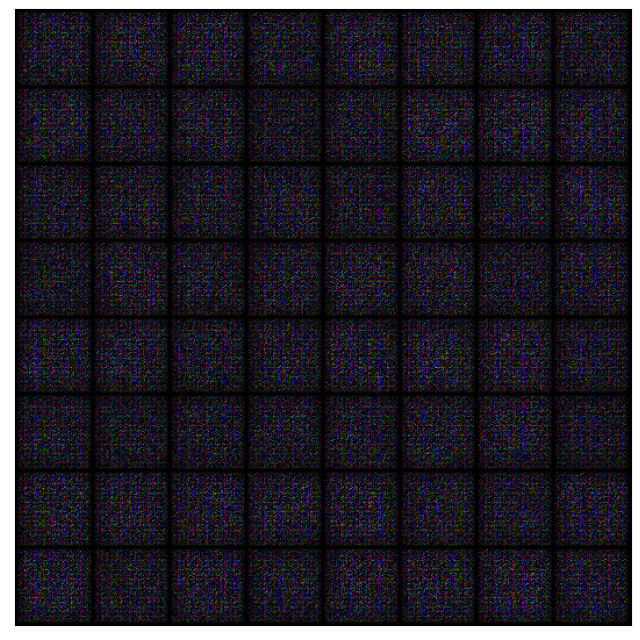

In [37]:
"""Generated Image before Training."""
save_samples(0, fixed_latent, fixed_labels)

### 5. Model Training

In [38]:
"""Fit Function"""

def fit(epochs, lr, start_idx = 1):
    torch.cuda.empty_cache()
    
    """Losses & scores"""
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    """Create optimizers"""
    opt_d = torch.optim.Adam(discriminator.parameters(), lr = lr, betas = (0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr = lr, betas = (0.5, 0.999))
     

    for epoch in range(epochs):
        for real_images, real_labels in tqdm(Train_Dl):
            # Train discriminator
            loss_d, real_score, fake_score = Train_Discriminator(real_images, real_labels, opt_d)
            # Train generator
            loss_g = Train_Generator(opt_g)
            
        """Record losses & scores"""
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        """Log losses & scores (last batch)"""
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        """Save generated images"""
        save_samples(epoch+start_idx, fixed_latent, fixed_labels, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [39]:
lr = 0.0001
epochs = 200

In [40]:
"""Kickstart of Train"""
history = fit(epochs, lr)

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [1/200], loss_g: 10.0336, loss_d: 0.0654, real_score: 0.9801, fake_score: 0.0381
Saving generated-images-0001.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [2/200], loss_g: 5.2029, loss_d: 0.0014, real_score: 1.0000, fake_score: 0.0014
Saving generated-images-0002.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [3/200], loss_g: 17.4234, loss_d: 0.2743, real_score: 0.9981, fake_score: 0.1846
Saving generated-images-0003.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [4/200], loss_g: 6.8134, loss_d: 0.0812, real_score: 0.9926, fake_score: 0.0667
Saving generated-images-0004.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [5/200], loss_g: 8.6490, loss_d: 0.0746, real_score: 0.9560, fake_score: 0.0002
Saving generated-images-0005.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [6/200], loss_g: 6.6765, loss_d: 0.1281, real_score: 0.9091, fake_score: 0.0045
Saving generated-images-0006.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [7/200], loss_g: 15.7756, loss_d: 0.0210, real_score: 0.9809, fake_score: 0.0000
Saving generated-images-0007.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [8/200], loss_g: 10.0438, loss_d: 0.4298, real_score: 0.8153, fake_score: 0.0001
Saving generated-images-0008.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [9/200], loss_g: 5.8282, loss_d: 0.0523, real_score: 0.9846, fake_score: 0.0345
Saving generated-images-0009.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [10/200], loss_g: 6.7062, loss_d: 0.0924, real_score: 0.9280, fake_score: 0.0058
Saving generated-images-0010.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [11/200], loss_g: 7.3616, loss_d: 0.1849, real_score: 0.8908, fake_score: 0.0101
Saving generated-images-0011.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [12/200], loss_g: 26.0165, loss_d: 4.3109, real_score: 0.2216, fake_score: 0.0000
Saving generated-images-0012.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [13/200], loss_g: 1.6908, loss_d: 0.9156, real_score: 0.5873, fake_score: 0.0094
Saving generated-images-0013.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [14/200], loss_g: 6.7137, loss_d: 0.5451, real_score: 0.9003, fake_score: 0.2438
Saving generated-images-0014.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [15/200], loss_g: 4.6747, loss_d: 0.1162, real_score: 0.9680, fake_score: 0.0708
Saving generated-images-0015.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [16/200], loss_g: 4.3677, loss_d: 0.1140, real_score: 0.9257, fake_score: 0.0077
Saving generated-images-0016.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [17/200], loss_g: 6.3877, loss_d: 0.1884, real_score: 0.9693, fake_score: 0.1211
Saving generated-images-0017.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [18/200], loss_g: 5.6433, loss_d: 0.1072, real_score: 0.9701, fake_score: 0.0645
Saving generated-images-0018.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [19/200], loss_g: 5.9923, loss_d: 0.2207, real_score: 0.9491, fake_score: 0.1102
Saving generated-images-0019.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [20/200], loss_g: 6.4258, loss_d: 0.1587, real_score: 0.9711, fake_score: 0.0987
Saving generated-images-0020.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [21/200], loss_g: 5.3625, loss_d: 0.1458, real_score: 0.9286, fake_score: 0.0540
Saving generated-images-0021.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [22/200], loss_g: 4.7575, loss_d: 0.1492, real_score: 0.9473, fake_score: 0.0653
Saving generated-images-0022.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [23/200], loss_g: 4.4599, loss_d: 0.1279, real_score: 0.9482, fake_score: 0.0431
Saving generated-images-0023.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [24/200], loss_g: 3.3129, loss_d: 0.4025, real_score: 0.7461, fake_score: 0.0312
Saving generated-images-0024.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [25/200], loss_g: 6.8560, loss_d: 0.0931, real_score: 0.9888, fake_score: 0.0640
Saving generated-images-0025.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [26/200], loss_g: 7.9976, loss_d: 0.4496, real_score: 0.9495, fake_score: 0.2631
Saving generated-images-0026.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [27/200], loss_g: 4.4282, loss_d: 0.2257, real_score: 0.8594, fake_score: 0.0269
Saving generated-images-0027.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [28/200], loss_g: 3.8016, loss_d: 1.7540, real_score: 0.3505, fake_score: 0.0001
Saving generated-images-0028.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [29/200], loss_g: 5.9729, loss_d: 0.5405, real_score: 0.8842, fake_score: 0.2072
Saving generated-images-0029.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [30/200], loss_g: 4.2856, loss_d: 0.2138, real_score: 0.8956, fake_score: 0.0629
Saving generated-images-0030.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [31/200], loss_g: 1.0582, loss_d: 0.3989, real_score: 0.7868, fake_score: 0.0399
Saving generated-images-0031.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [32/200], loss_g: 5.8752, loss_d: 0.5974, real_score: 0.9859, fake_score: 0.3279
Saving generated-images-0032.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [33/200], loss_g: 5.4633, loss_d: 0.3654, real_score: 0.9738, fake_score: 0.2385
Saving generated-images-0033.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [34/200], loss_g: 3.0910, loss_d: 0.3656, real_score: 0.8043, fake_score: 0.0611
Saving generated-images-0034.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [35/200], loss_g: 5.7424, loss_d: 0.4842, real_score: 0.9362, fake_score: 0.2743
Saving generated-images-0035.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [36/200], loss_g: 3.3095, loss_d: 0.4260, real_score: 0.9202, fake_score: 0.2219
Saving generated-images-0036.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [37/200], loss_g: 4.0077, loss_d: 0.4077, real_score: 0.8732, fake_score: 0.1799
Saving generated-images-0037.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [38/200], loss_g: 5.1261, loss_d: 0.5260, real_score: 0.9419, fake_score: 0.3201
Saving generated-images-0038.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [39/200], loss_g: 5.3568, loss_d: 0.3541, real_score: 0.8400, fake_score: 0.0994
Saving generated-images-0039.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [40/200], loss_g: 2.7653, loss_d: 0.2183, real_score: 0.8952, fake_score: 0.0707
Saving generated-images-0040.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [41/200], loss_g: 3.5854, loss_d: 0.4359, real_score: 0.8312, fake_score: 0.1681
Saving generated-images-0041.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [42/200], loss_g: 3.5416, loss_d: 0.4347, real_score: 0.7667, fake_score: 0.0440
Saving generated-images-0042.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [43/200], loss_g: 4.2340, loss_d: 0.1554, real_score: 0.9408, fake_score: 0.0721
Saving generated-images-0043.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [44/200], loss_g: 5.2611, loss_d: 0.8618, real_score: 0.9443, fake_score: 0.4237
Saving generated-images-0044.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [45/200], loss_g: 2.5398, loss_d: 0.3424, real_score: 0.8004, fake_score: 0.0260
Saving generated-images-0045.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [46/200], loss_g: 3.9475, loss_d: 0.3648, real_score: 0.8060, fake_score: 0.0649
Saving generated-images-0046.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [47/200], loss_g: 1.9421, loss_d: 0.8350, real_score: 0.5792, fake_score: 0.0154
Saving generated-images-0047.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [48/200], loss_g: 5.0943, loss_d: 0.6232, real_score: 0.9151, fake_score: 0.3270
Saving generated-images-0048.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [49/200], loss_g: 1.7182, loss_d: 0.3238, real_score: 0.7947, fake_score: 0.0346
Saving generated-images-0049.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [50/200], loss_g: 4.9342, loss_d: 0.3738, real_score: 0.9758, fake_score: 0.2600
Saving generated-images-0050.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [51/200], loss_g: 4.2627, loss_d: 0.3070, real_score: 0.8532, fake_score: 0.0643
Saving generated-images-0051.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [52/200], loss_g: 2.7066, loss_d: 0.9650, real_score: 0.5468, fake_score: 0.0044
Saving generated-images-0052.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [53/200], loss_g: 2.7202, loss_d: 0.4238, real_score: 0.7340, fake_score: 0.0180
Saving generated-images-0053.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [54/200], loss_g: 3.0579, loss_d: 1.1758, real_score: 0.4992, fake_score: 0.0020
Saving generated-images-0054.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [55/200], loss_g: 2.1306, loss_d: 0.3116, real_score: 0.8375, fake_score: 0.0727
Saving generated-images-0055.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [56/200], loss_g: 2.2550, loss_d: 0.5063, real_score: 0.7719, fake_score: 0.0936
Saving generated-images-0056.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [57/200], loss_g: 3.9852, loss_d: 0.3706, real_score: 0.9044, fake_score: 0.1760
Saving generated-images-0057.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [58/200], loss_g: 2.1616, loss_d: 0.3295, real_score: 0.7791, fake_score: 0.0260
Saving generated-images-0058.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [59/200], loss_g: 4.3850, loss_d: 0.3069, real_score: 0.8810, fake_score: 0.1188
Saving generated-images-0059.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [60/200], loss_g: 8.0641, loss_d: 0.9669, real_score: 0.9946, fake_score: 0.4962
Saving generated-images-0060.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [61/200], loss_g: 6.4518, loss_d: 0.5856, real_score: 0.9792, fake_score: 0.3617
Saving generated-images-0061.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [62/200], loss_g: 4.0622, loss_d: 0.1782, real_score: 0.8896, fake_score: 0.0435
Saving generated-images-0062.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [63/200], loss_g: 6.1929, loss_d: 0.5738, real_score: 0.9849, fake_score: 0.3593
Saving generated-images-0063.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [64/200], loss_g: 3.6317, loss_d: 0.2365, real_score: 0.8637, fake_score: 0.0513
Saving generated-images-0064.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [65/200], loss_g: 5.0313, loss_d: 0.2260, real_score: 0.9668, fake_score: 0.1461
Saving generated-images-0065.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [66/200], loss_g: 4.7984, loss_d: 0.5327, real_score: 0.9706, fake_score: 0.3207
Saving generated-images-0066.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [67/200], loss_g: 2.8223, loss_d: 0.3302, real_score: 0.8562, fake_score: 0.0826
Saving generated-images-0067.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [68/200], loss_g: 2.8470, loss_d: 0.3652, real_score: 0.8069, fake_score: 0.0844
Saving generated-images-0068.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [69/200], loss_g: 7.8315, loss_d: 0.6335, real_score: 0.9585, fake_score: 0.3257
Saving generated-images-0069.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [70/200], loss_g: 4.1164, loss_d: 0.3284, real_score: 0.8860, fake_score: 0.1302
Saving generated-images-0070.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [71/200], loss_g: 2.7782, loss_d: 0.2755, real_score: 0.8383, fake_score: 0.0555
Saving generated-images-0071.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [72/200], loss_g: 5.2175, loss_d: 0.2817, real_score: 0.9351, fake_score: 0.1590
Saving generated-images-0072.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [73/200], loss_g: 2.2715, loss_d: 0.9770, real_score: 0.5393, fake_score: 0.0027
Saving generated-images-0073.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [74/200], loss_g: 3.7728, loss_d: 0.1880, real_score: 0.9046, fake_score: 0.0733
Saving generated-images-0074.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [75/200], loss_g: 3.1435, loss_d: 0.2113, real_score: 0.8646, fake_score: 0.0399
Saving generated-images-0075.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [76/200], loss_g: 2.8995, loss_d: 0.4958, real_score: 0.6965, fake_score: 0.0246
Saving generated-images-0076.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [77/200], loss_g: 4.1862, loss_d: 0.2720, real_score: 0.8699, fake_score: 0.0920
Saving generated-images-0077.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [78/200], loss_g: 3.8182, loss_d: 0.1909, real_score: 0.9220, fake_score: 0.0782
Saving generated-images-0078.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [79/200], loss_g: 3.8679, loss_d: 0.2656, real_score: 0.9233, fake_score: 0.1304
Saving generated-images-0079.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [80/200], loss_g: 1.9484, loss_d: 0.2217, real_score: 0.8893, fake_score: 0.0741
Saving generated-images-0080.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [81/200], loss_g: 3.1884, loss_d: 0.1873, real_score: 0.9261, fake_score: 0.0657
Saving generated-images-0081.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [82/200], loss_g: 4.5943, loss_d: 0.2283, real_score: 0.9589, fake_score: 0.1514
Saving generated-images-0082.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [83/200], loss_g: 3.8057, loss_d: 0.1438, real_score: 0.9551, fake_score: 0.0817
Saving generated-images-0083.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [84/200], loss_g: 3.2260, loss_d: 0.3472, real_score: 0.8213, fake_score: 0.0686
Saving generated-images-0084.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [85/200], loss_g: 4.9881, loss_d: 0.2692, real_score: 0.9844, fake_score: 0.1911
Saving generated-images-0085.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [86/200], loss_g: 4.3843, loss_d: 0.3746, real_score: 0.9896, fake_score: 0.2668
Saving generated-images-0086.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [87/200], loss_g: 4.2812, loss_d: 0.3803, real_score: 0.9915, fake_score: 0.2687
Saving generated-images-0087.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [88/200], loss_g: 3.6949, loss_d: 0.2186, real_score: 0.9263, fake_score: 0.1128
Saving generated-images-0088.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [89/200], loss_g: 7.1085, loss_d: 0.6253, real_score: 0.9603, fake_score: 0.3524
Saving generated-images-0089.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [90/200], loss_g: 5.8851, loss_d: 0.1532, real_score: 0.8987, fake_score: 0.0214
Saving generated-images-0090.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [91/200], loss_g: 7.2060, loss_d: 0.4995, real_score: 0.9539, fake_score: 0.2472
Saving generated-images-0091.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [92/200], loss_g: 4.4838, loss_d: 0.1899, real_score: 0.9316, fake_score: 0.0820
Saving generated-images-0092.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [93/200], loss_g: 5.4324, loss_d: 0.2204, real_score: 0.9671, fake_score: 0.1378
Saving generated-images-0093.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [94/200], loss_g: 1.4330, loss_d: 0.4563, real_score: 0.7649, fake_score: 0.0696
Saving generated-images-0094.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [95/200], loss_g: 3.8740, loss_d: 0.1810, real_score: 0.9314, fake_score: 0.0773
Saving generated-images-0095.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [96/200], loss_g: 3.3743, loss_d: 0.1169, real_score: 0.9293, fake_score: 0.0271
Saving generated-images-0096.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [97/200], loss_g: 3.5986, loss_d: 0.2529, real_score: 0.9685, fake_score: 0.1515
Saving generated-images-0097.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [98/200], loss_g: 5.2234, loss_d: 0.0954, real_score: 0.9360, fake_score: 0.0201
Saving generated-images-0098.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [99/200], loss_g: 4.9496, loss_d: 0.2184, real_score: 0.9514, fake_score: 0.1207
Saving generated-images-0099.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [100/200], loss_g: 3.6209, loss_d: 0.2236, real_score: 0.8429, fake_score: 0.0176
Saving generated-images-0100.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [101/200], loss_g: 3.7405, loss_d: 0.2172, real_score: 0.9011, fake_score: 0.0784
Saving generated-images-0101.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [102/200], loss_g: 6.5002, loss_d: 0.2446, real_score: 0.9549, fake_score: 0.1540
Saving generated-images-0102.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [103/200], loss_g: 3.7738, loss_d: 0.5002, real_score: 0.6861, fake_score: 0.0056
Saving generated-images-0103.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [104/200], loss_g: 3.5944, loss_d: 0.1938, real_score: 0.8949, fake_score: 0.0281
Saving generated-images-0104.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [105/200], loss_g: 8.3466, loss_d: 0.4800, real_score: 0.9654, fake_score: 0.3034
Saving generated-images-0105.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [106/200], loss_g: 3.9879, loss_d: 0.1550, real_score: 0.9005, fake_score: 0.0248
Saving generated-images-0106.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [107/200], loss_g: 3.5412, loss_d: 0.2025, real_score: 0.8679, fake_score: 0.0261
Saving generated-images-0107.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [108/200], loss_g: 0.6805, loss_d: 0.7773, real_score: 0.5944, fake_score: 0.0035
Saving generated-images-0108.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [109/200], loss_g: 3.8928, loss_d: 0.1737, real_score: 0.9507, fake_score: 0.0957
Saving generated-images-0109.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [110/200], loss_g: 4.8086, loss_d: 0.1379, real_score: 0.9791, fake_score: 0.0996
Saving generated-images-0110.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [111/200], loss_g: 3.4755, loss_d: 0.3162, real_score: 0.7937, fake_score: 0.0083
Saving generated-images-0111.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [112/200], loss_g: 4.6340, loss_d: 0.1515, real_score: 0.8885, fake_score: 0.0134
Saving generated-images-0112.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [113/200], loss_g: 3.5858, loss_d: 0.1711, real_score: 0.9115, fake_score: 0.0554
Saving generated-images-0113.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [114/200], loss_g: 5.4728, loss_d: 0.1349, real_score: 0.9461, fake_score: 0.0591
Saving generated-images-0114.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [115/200], loss_g: 4.0841, loss_d: 0.2208, real_score: 0.9841, fake_score: 0.1595
Saving generated-images-0115.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [116/200], loss_g: 5.9042, loss_d: 0.1176, real_score: 0.9729, fake_score: 0.0750
Saving generated-images-0116.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [117/200], loss_g: 4.6453, loss_d: 0.1120, real_score: 0.9390, fake_score: 0.0331
Saving generated-images-0117.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [118/200], loss_g: 3.6474, loss_d: 0.3011, real_score: 0.8137, fake_score: 0.0277
Saving generated-images-0118.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [119/200], loss_g: 5.1616, loss_d: 0.0744, real_score: 0.9585, fake_score: 0.0276
Saving generated-images-0119.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [120/200], loss_g: 5.3373, loss_d: 0.1223, real_score: 0.9754, fake_score: 0.0773
Saving generated-images-0120.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [121/200], loss_g: 4.3181, loss_d: 0.1927, real_score: 0.9321, fake_score: 0.0705
Saving generated-images-0121.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [122/200], loss_g: 4.7338, loss_d: 0.1800, real_score: 0.9769, fake_score: 0.1201
Saving generated-images-0122.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [123/200], loss_g: 6.4316, loss_d: 0.0939, real_score: 0.9361, fake_score: 0.0141
Saving generated-images-0123.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [124/200], loss_g: 9.8413, loss_d: 0.7642, real_score: 0.9968, fake_score: 0.4037
Saving generated-images-0124.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [125/200], loss_g: 4.7611, loss_d: 0.1305, real_score: 0.9917, fake_score: 0.1010
Saving generated-images-0125.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [126/200], loss_g: 4.2937, loss_d: 0.1542, real_score: 0.9823, fake_score: 0.1061
Saving generated-images-0126.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [127/200], loss_g: 5.8429, loss_d: 0.1296, real_score: 0.9614, fake_score: 0.0755
Saving generated-images-0127.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [128/200], loss_g: 4.7605, loss_d: 0.1147, real_score: 0.9708, fake_score: 0.0709
Saving generated-images-0128.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [129/200], loss_g: 5.4410, loss_d: 0.0551, real_score: 0.9632, fake_score: 0.0106
Saving generated-images-0129.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [130/200], loss_g: 4.4263, loss_d: 0.0560, real_score: 0.9855, fake_score: 0.0382
Saving generated-images-0130.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [131/200], loss_g: 4.6344, loss_d: 0.0759, real_score: 0.9912, fake_score: 0.0608
Saving generated-images-0131.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [132/200], loss_g: 5.8849, loss_d: 0.1024, real_score: 0.9915, fake_score: 0.0757
Saving generated-images-0132.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [133/200], loss_g: 4.1883, loss_d: 0.0780, real_score: 0.9500, fake_score: 0.0220
Saving generated-images-0133.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [134/200], loss_g: 5.8080, loss_d: 0.1139, real_score: 0.9821, fake_score: 0.0789
Saving generated-images-0134.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [135/200], loss_g: 5.7678, loss_d: 0.0899, real_score: 0.9546, fake_score: 0.0296
Saving generated-images-0135.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [136/200], loss_g: 4.3688, loss_d: 0.0775, real_score: 0.9681, fake_score: 0.0361
Saving generated-images-0136.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [137/200], loss_g: 5.7201, loss_d: 0.1070, real_score: 0.9884, fake_score: 0.0830
Saving generated-images-0137.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [138/200], loss_g: 4.4423, loss_d: 0.0822, real_score: 0.9785, fake_score: 0.0508
Saving generated-images-0138.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [139/200], loss_g: 4.1065, loss_d: 0.3986, real_score: 0.8307, fake_score: 0.0619
Saving generated-images-0139.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [140/200], loss_g: 4.3332, loss_d: 0.0908, real_score: 0.9518, fake_score: 0.0311
Saving generated-images-0140.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [141/200], loss_g: 3.8822, loss_d: 0.0908, real_score: 0.9388, fake_score: 0.0180
Saving generated-images-0141.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [142/200], loss_g: 5.4324, loss_d: 0.0869, real_score: 0.9508, fake_score: 0.0223
Saving generated-images-0142.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [143/200], loss_g: 5.1225, loss_d: 0.0862, real_score: 0.9602, fake_score: 0.0372
Saving generated-images-0143.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [144/200], loss_g: 5.3055, loss_d: 0.1693, real_score: 0.9810, fake_score: 0.1202
Saving generated-images-0144.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [145/200], loss_g: 5.0059, loss_d: 0.1008, real_score: 0.9849, fake_score: 0.0726
Saving generated-images-0145.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [146/200], loss_g: 4.5208, loss_d: 0.5494, real_score: 0.9334, fake_score: 0.1681
Saving generated-images-0146.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [147/200], loss_g: 2.9642, loss_d: 0.1542, real_score: 0.9020, fake_score: 0.0178
Saving generated-images-0147.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [148/200], loss_g: 6.7415, loss_d: 0.0531, real_score: 0.9805, fake_score: 0.0296
Saving generated-images-0148.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [149/200], loss_g: 5.1986, loss_d: 0.1119, real_score: 0.9694, fake_score: 0.0645
Saving generated-images-0149.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [150/200], loss_g: 5.5275, loss_d: 0.1636, real_score: 0.9792, fake_score: 0.1126
Saving generated-images-0150.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [151/200], loss_g: 3.6581, loss_d: 0.1534, real_score: 0.8969, fake_score: 0.0237
Saving generated-images-0151.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [152/200], loss_g: 6.0434, loss_d: 0.1847, real_score: 0.9658, fake_score: 0.1002
Saving generated-images-0152.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [153/200], loss_g: 4.8265, loss_d: 0.0926, real_score: 0.9874, fake_score: 0.0679
Saving generated-images-0153.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [154/200], loss_g: 6.2482, loss_d: 0.5623, real_score: 0.9836, fake_score: 0.3021
Saving generated-images-0154.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [155/200], loss_g: 4.5978, loss_d: 0.0846, real_score: 0.9548, fake_score: 0.0309
Saving generated-images-0155.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [156/200], loss_g: 4.6351, loss_d: 0.0732, real_score: 0.9673, fake_score: 0.0347
Saving generated-images-0156.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [157/200], loss_g: 5.3047, loss_d: 0.0736, real_score: 0.9522, fake_score: 0.0206
Saving generated-images-0157.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [158/200], loss_g: 6.0379, loss_d: 0.0853, real_score: 0.9772, fake_score: 0.0418
Saving generated-images-0158.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [159/200], loss_g: 3.9463, loss_d: 0.1270, real_score: 0.9432, fake_score: 0.0420
Saving generated-images-0159.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [160/200], loss_g: 3.6464, loss_d: 0.0958, real_score: 0.9395, fake_score: 0.0191
Saving generated-images-0160.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [161/200], loss_g: 5.3513, loss_d: 0.0494, real_score: 0.9744, fake_score: 0.0169
Saving generated-images-0161.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [162/200], loss_g: 4.2324, loss_d: 0.0573, real_score: 0.9636, fake_score: 0.0166
Saving generated-images-0162.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [163/200], loss_g: 4.4016, loss_d: 0.0707, real_score: 0.9653, fake_score: 0.0270
Saving generated-images-0163.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [164/200], loss_g: 4.4612, loss_d: 0.0366, real_score: 0.9708, fake_score: 0.0056
Saving generated-images-0164.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [165/200], loss_g: 6.1860, loss_d: 0.0604, real_score: 0.9853, fake_score: 0.0384
Saving generated-images-0165.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [166/200], loss_g: 4.7281, loss_d: 0.1344, real_score: 0.8981, fake_score: 0.0084
Saving generated-images-0166.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [167/200], loss_g: 5.5398, loss_d: 0.1336, real_score: 0.9599, fake_score: 0.0756
Saving generated-images-0167.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [168/200], loss_g: 5.0517, loss_d: 0.1224, real_score: 0.9887, fake_score: 0.0892
Saving generated-images-0168.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [169/200], loss_g: 5.1329, loss_d: 0.0535, real_score: 0.9707, fake_score: 0.0182
Saving generated-images-0169.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [170/200], loss_g: 5.7409, loss_d: 0.0887, real_score: 0.9668, fake_score: 0.0448
Saving generated-images-0170.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [171/200], loss_g: 6.9454, loss_d: 0.1763, real_score: 0.9969, fake_score: 0.1306
Saving generated-images-0171.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [172/200], loss_g: 6.0362, loss_d: 0.1675, real_score: 0.9983, fake_score: 0.1262
Saving generated-images-0172.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [173/200], loss_g: 3.6868, loss_d: 0.1132, real_score: 0.9420, fake_score: 0.0382
Saving generated-images-0173.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [174/200], loss_g: 5.9614, loss_d: 0.1360, real_score: 0.9562, fake_score: 0.0536
Saving generated-images-0174.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [175/200], loss_g: 5.5625, loss_d: 0.0602, real_score: 0.9671, fake_score: 0.0223
Saving generated-images-0175.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [176/200], loss_g: 5.1685, loss_d: 0.0417, real_score: 0.9868, fake_score: 0.0266
Saving generated-images-0176.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [177/200], loss_g: 5.1699, loss_d: 0.0983, real_score: 0.9357, fake_score: 0.0140
Saving generated-images-0177.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [178/200], loss_g: 4.9785, loss_d: 0.0779, real_score: 0.9747, fake_score: 0.0424
Saving generated-images-0178.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [179/200], loss_g: 6.4064, loss_d: 0.0501, real_score: 0.9837, fake_score: 0.0308
Saving generated-images-0179.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [180/200], loss_g: 4.7674, loss_d: 0.0802, real_score: 0.9416, fake_score: 0.0122
Saving generated-images-0180.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [181/200], loss_g: 4.5934, loss_d: 0.1022, real_score: 0.9430, fake_score: 0.0289
Saving generated-images-0181.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [182/200], loss_g: 5.3497, loss_d: 0.0875, real_score: 0.9309, fake_score: 0.0066
Saving generated-images-0182.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [183/200], loss_g: 5.0707, loss_d: 0.0922, real_score: 0.9550, fake_score: 0.0347
Saving generated-images-0183.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [184/200], loss_g: 4.1862, loss_d: 0.0554, real_score: 0.9964, fake_score: 0.0460
Saving generated-images-0184.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [185/200], loss_g: 5.3492, loss_d: 0.0913, real_score: 0.9574, fake_score: 0.0383
Saving generated-images-0185.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [186/200], loss_g: 7.8466, loss_d: 0.0333, real_score: 0.9911, fake_score: 0.0208
Saving generated-images-0186.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [187/200], loss_g: 4.6038, loss_d: 0.0606, real_score: 0.9922, fake_score: 0.0466
Saving generated-images-0187.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [188/200], loss_g: 12.5847, loss_d: 1.2921, real_score: 0.9998, fake_score: 0.5550
Saving generated-images-0188.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [189/200], loss_g: 3.6494, loss_d: 0.0772, real_score: 0.9574, fake_score: 0.0256
Saving generated-images-0189.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [190/200], loss_g: 5.6816, loss_d: 0.0527, real_score: 0.9659, fake_score: 0.0116
Saving generated-images-0190.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [191/200], loss_g: 4.4105, loss_d: 0.0534, real_score: 0.9732, fake_score: 0.0205
Saving generated-images-0191.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [192/200], loss_g: 4.5477, loss_d: 0.0763, real_score: 0.9462, fake_score: 0.0067
Saving generated-images-0192.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [193/200], loss_g: 5.3448, loss_d: 0.0529, real_score: 0.9840, fake_score: 0.0309
Saving generated-images-0193.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [194/200], loss_g: 5.4404, loss_d: 0.0644, real_score: 0.9699, fake_score: 0.0271
Saving generated-images-0194.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [195/200], loss_g: 5.5236, loss_d: 0.0401, real_score: 0.9738, fake_score: 0.0118
Saving generated-images-0195.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [196/200], loss_g: 5.9189, loss_d: 0.0764, real_score: 0.9927, fake_score: 0.0604
Saving generated-images-0196.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [197/200], loss_g: 2.0352, loss_d: 0.2951, real_score: 0.8297, fake_score: 0.0094
Saving generated-images-0197.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [198/200], loss_g: 4.3056, loss_d: 0.0511, real_score: 0.9850, fake_score: 0.0312
Saving generated-images-0198.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [199/200], loss_g: 4.9052, loss_d: 0.0614, real_score: 0.9695, fake_score: 0.0072
Saving generated-images-0199.png


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [200/200], loss_g: 4.3550, loss_d: 0.0858, real_score: 0.9620, fake_score: 0.0371
Saving generated-images-0200.png


In [41]:
"""Save the model checkpoints.""" 
torch.save(generator.state_dict(), 'G_bitmoji_condition.pth')
torch.save(discriminator.state_dict(), 'D_bitmoji_condition.pth')

### 6. Visualization of loss and scores

In [42]:
losses_g, losses_d, real_scores, fake_scores = history

In [5]:
"""Create Video for Generated Images."""

vid_fname = 'gans_bitmoji_faces_condition_1.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated-images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 13, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

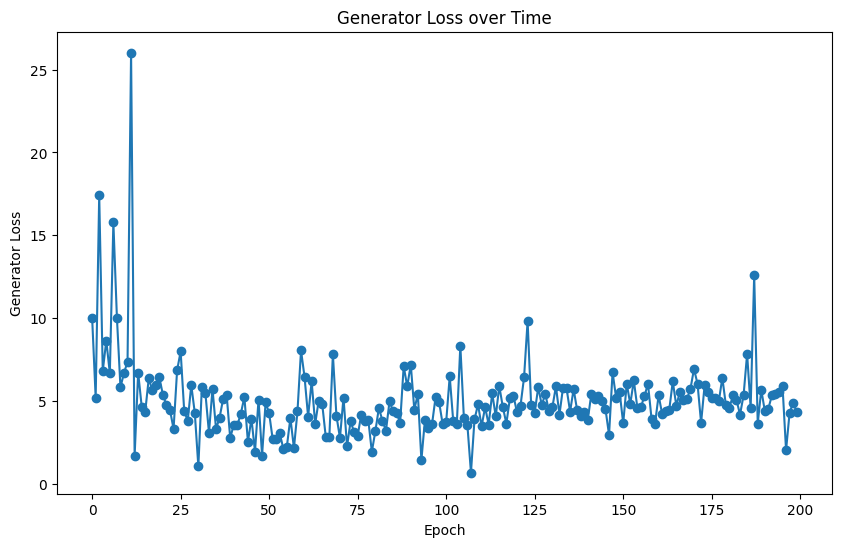

In [44]:
x = range(len(losses_g))

plt.figure(figsize=(10,6))
plt.plot(x, losses_g ,'-')
plt.scatter(x, losses_g)
plt.xlabel('Epoch')
plt.ylabel('Generator Loss')
plt.title('Generator Loss over Time')
plt.show()

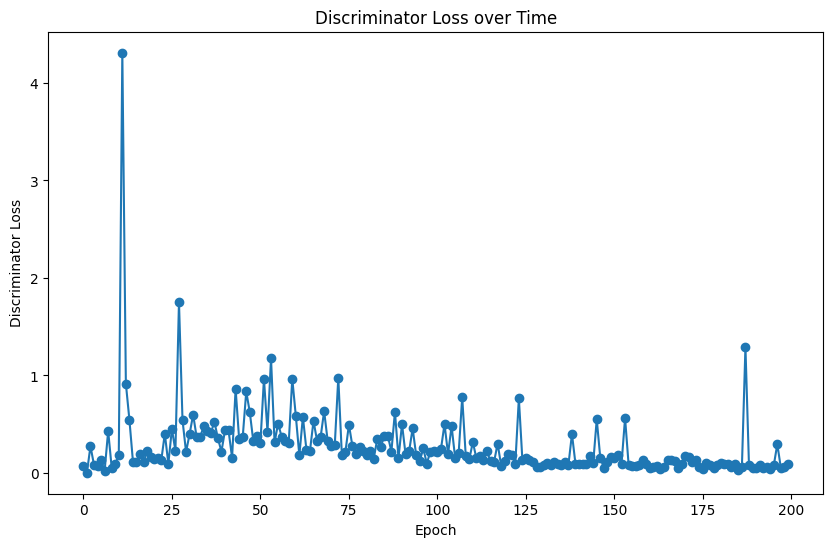

In [45]:
x = range(len(losses_d))

plt.figure(figsize=(10,6))
plt.plot(x, losses_d ,'-')
plt.scatter(x, losses_d)
plt.xlabel('Epoch')
plt.ylabel('Discriminator Loss')
plt.title('Discriminator Loss over Time')
plt.show()

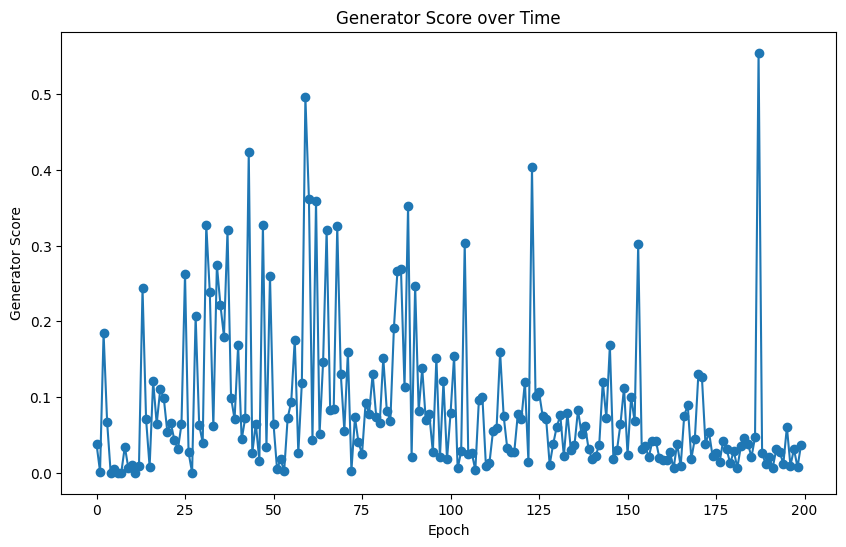

In [46]:
x = range(len(fake_scores))

plt.figure(figsize=(10,6))
plt.plot(x, fake_scores ,'-')
plt.scatter(x, fake_scores)
plt.xlabel('Epoch')
plt.ylabel('Generator Score')
plt.title('Generator Score over Time')
plt.show()

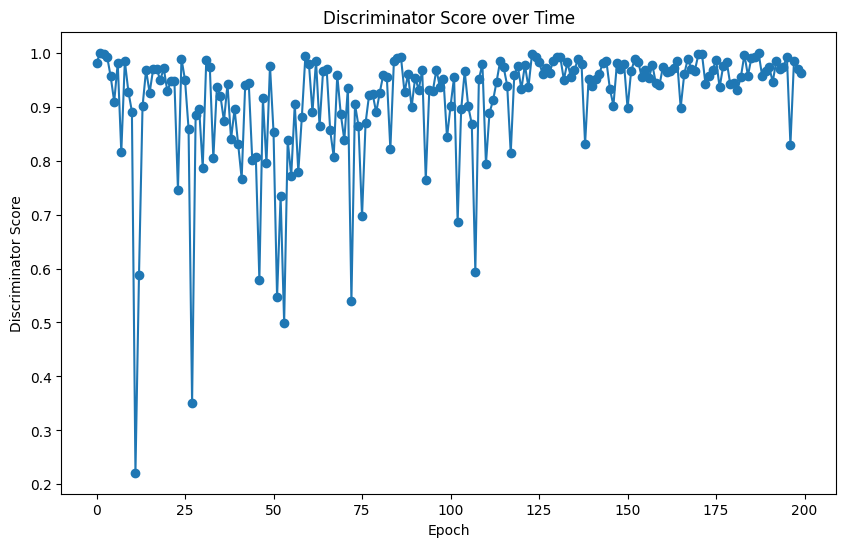

In [47]:
x = range(len(real_scores))

plt.figure(figsize=(10, 6))
plt.plot(x, real_scores ,'-')
plt.scatter(x, real_scores)
plt.xlabel('Epoch')
plt.ylabel('Discriminator Score')
plt.title('Discriminator Score over Time')
plt.show()

Text(0.5, 1.0, 'Losses')

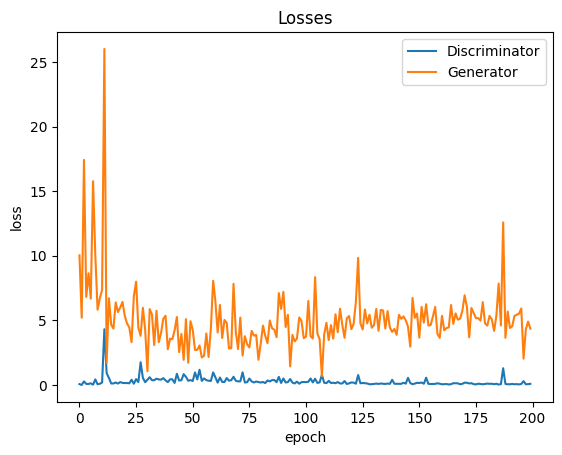

In [48]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

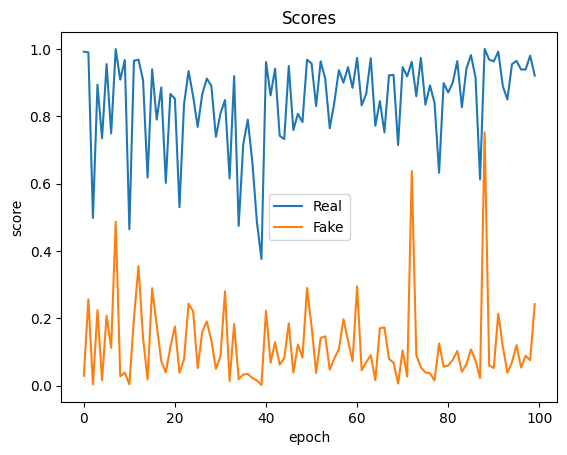

In [64]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

### 7. Image Generation

torch.Size([32, 3, 64, 64])


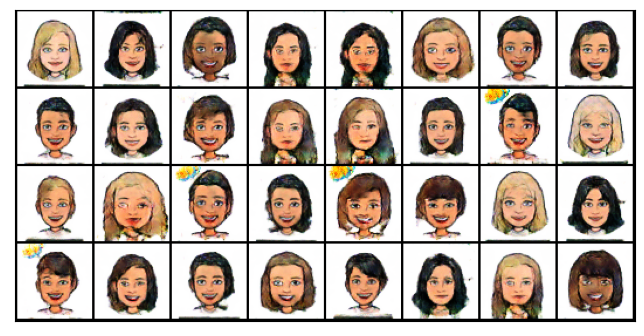

In [58]:
""" Generating Bitmoji Faces for Female Category."""

num = 32
xb = torch.randn(num, latent_dim, device = device) # random latent tensors
yb = torch.randint(0, 1, size = (num, 1), device = device, dtype = torch.int64)
fake_images = generator(xb, yb)
print(fake_images.shape)
show_images(fake_images)

torch.Size([32, 3, 64, 64])


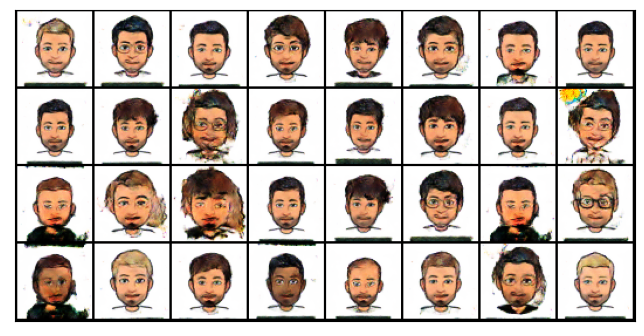

In [71]:
""" Generating Bitmoji Faces for Male Category."""

xb = torch.randn(num, latent_dim, device = device) # random latent tensors
yb = torch.randint(1, 2, size = (num, 1), device = device, dtype = torch.int64)
fake_images = generator(xb, yb)
print(fake_images.shape)
show_images(fake_images)

#### Conclusion:
    1. This model is able to generate Bitmoji Faces for the given random vectors and gender.
    2. Unlike DCGANS, this approach can be used to generate particular images for our use cases.